# Weighted K-Means Clustering

In this exercise we will simulate finding good locations for production plants of a company in order to minimize its logistical costs. In particular, we would like to place production plants near customers so as to reduce shipping costs and delivery time.

We assume that the probability of someone being a customer is independent of its geographical location and that the overall cost of delivering products to customers is proportional to the squared Euclidean distance to the closest production plant. Under these assumptions, the K-Means algorithm is an appropriate method to find a good set of locations. Indeed, K-Means finds a spatial clustering of potential customers and the centroid of each cluster can be chosen to be the location of the plant.

Because there are potentially millions of customers, and that it is not scalable to model each customer as a data point in the K-Means procedure, we consider instead as many points as there are geographical locations, and assign to each geographical location a weight $w_i$ corresponding to the number of inhabitants at that location. The resulting problem becomes a weighted version of K-Means where we seek to minimize the objective:

$$
J(c_1,\dots,c_K) = \frac{\sum_{i} w_i \min_k ||x_i-c_k||^2}{\sum_{i} w_i},
$$

where $c_k$ is the $k$'th centroid, and $w_i$ is the weight of each geographical coordinate $x_i$. In order to minimize this cost function, we iteratively perform the following EM computations:

* **Expectation step:** Compute the set of points associated to each centroid:
$$
\forall~1 \leq k \leq K: \quad \mathcal{C}(k) \leftarrow \Big\{ i ~:~ k = \mathrm{arg}\min_k \| x_i - c_k \|^2 \Big\}
$$


* **Minimization step:** Recompute the centroid as a the (weighted) mean of the associated data points:
$$
\forall~1 \leq k \leq K: \quad c_k \leftarrow \frac{\sum_{i \in \mathcal{C}(k)} w_i \cdot x_i}{\sum_{i \in \mathcal{C}(k)} w_i}
$$


until the objective $J(c_1,\dots,c_K)$ has converged.


## Getting started

In this exercise we will use data from http://sedac.ciesin.columbia.edu/, that we store in the files `data.mat` as part of the zip archive. The data contains for each geographical coordinates (latitude and longitude), the number of inhabitants and the corresponding country. Several variables and methods are provided in the file `utils.py`:


*  **`utils.population`** A 2D array with the number of inhabitants at each latitude/longitude.


*  **`utils.plot(latitudes,longitudes)`** Plot a list of centroids given as geographical coordinates in overlay to the population density map.

The code below plots three factories (white squares) with geographical coordinates (60,80),
(60,90),(60,100) given as input.

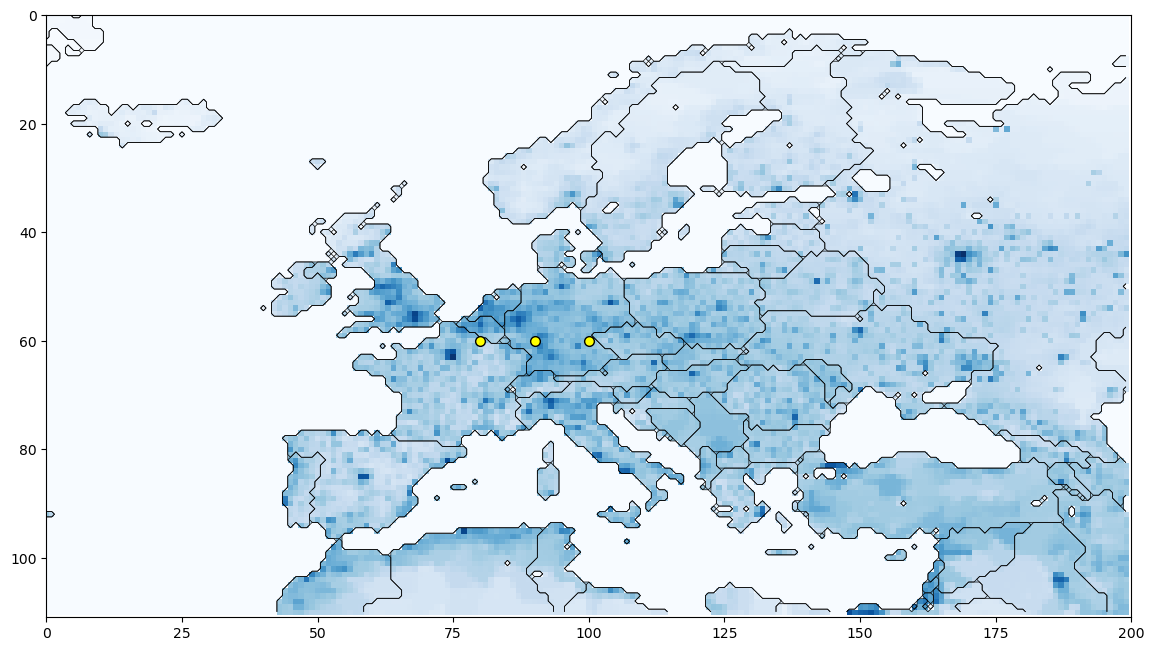

In [1]:
import src.utils as utils
import numpy as np
from pathlib import Path
import scipy.spatial.distance as sd
import imageio
import os

%matplotlib inline
utils.plot([60,60,60],[80,90,100])

Also, to get a dataset of geographical coordinates associated to the image given as an array, we can use:

In [2]:
x,y = np.indices(utils.population.shape)
locations = np.array([x.flatten(),y.flatten()]).T

## Initializing Weighted K-Means (25 P)

Because K-means has a non-convex objective, choosing a good initial set of centroids is important. Centroids are drawn from the following discrete probability distribution:

$$
P(x,y) = \frac1Z \cdot \text{population}(x,y)
$$

where $Z$ is a normalization constant. Furthermore, to avoid identical centroids, we add a small Gaussian noise to the location of centroids, with standard deviation $0.01$.

**Task:**

* **Implement the initialization procedure above.**

In [3]:
def initialize(K, population):
    """
    Initializes centroids for weighted k-means based on population density.
    
    Parameters:
    - K (int): Number of centroids.
    - population (2D numpy array): Population density matrix.

    Returns:
    - centroids (2D numpy array): Array of shape (K, 2) with centroid coordinates.
    """
    population = population.astype('float64')
    p = population / population.sum()

    # Select indices based on population density
    centroids = np.random.choice(np.arange(p.size), [K], p=p.flatten())

    # Convert 1D indices to 2D coordinates
    centroids = np.unravel_index(centroids, p.shape)

    centroids = np.concatenate([
        centroids[0][:,np.newaxis], 
        centroids[1][:,np.newaxis]
        ], axis=1)

    # Add small noise to centroids to avoid duplicate points
    centroids = centroids + np.random.normal(0, 0.01, centroids.shape)

    return centroids


The following code runs the initialization procedure for K=200 clusters and visualizes the centroids obtained with the initialization procedure using `utils.plot`.

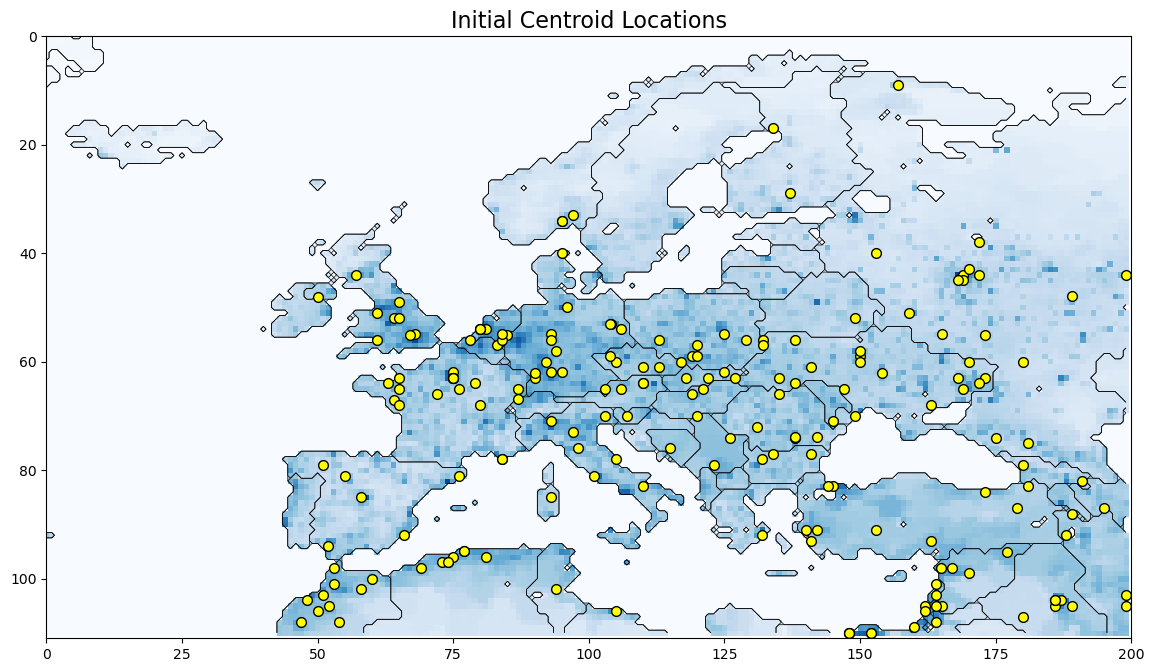

In [4]:
centroids_init = initialize(200, utils.population)
utils.plot(centroids_init[:,0], centroids_init[:,1], filename="plots/initialization_centroids_k200.png", title="Initial Centroid Locations", show=True)


## Implementing Weighted K-Means (75 P)

**Task:**


* **Implement the weighted K-Means algorithm. Your algorithm should run for `nbit` iterations and print the value of the objective after training. If `verbose`, it should also print the value of the objective at each iteration.**

In [5]:
def wkmeans(centroids, points, weights, verbose=False, nbit=30, gif_dir="plots/gif_frames"):
    """
    Performs weighted k-means clustering.

    Parameters:
    - centroids (numpy array): Initial cluster centers, shape (K, 2).
    - points (numpy array): Data points, shape (N, 2).
    - weights (numpy array): Weights for each point, shape (N,).
    - verbose (bool): If True, prints progress.
    - nbit (int): Number of iterations.

    Returns:
    - centroids (numpy array): Updated centroids after clustering.
    """
    eps = 1e-8  # Small value to avoid division by zero
    
    for i in range(nbit):
        # E Step - Assign points to nearest centroid
        dist = sd.cdist(points, centroids, 'sqeuclidean')
        allocation = np.argmin(dist, axis=1)

        # M Step - Update centroids
        J = 0

        for k in range(len(centroids)):

            p = points[allocation == k]
            w = weights[allocation == k]
            
            # Update centroids using weighted mean
            centroids[k] = (p * w[:, np.newaxis]).sum(axis=0) / (w.sum(axis=0) + eps)
            
            # Compute cost function J
            J += (w * ((p - centroids[k])**2).sum(axis=1)).sum()
        
        J /= weights.sum() + eps  # Normalize cost function
        
        if verbose or i == nbit-1:
            print(f'Iteration {i+1}: J={J:.4f}')

        if gif_dir:
            frame_path = Path(gif_dir) / f"iter_{i:02d}.png"
            utils.plot(centroids[:,0], centroids[:,1], filename=frame_path, title=f"Iteration {i+1}", show=False)        
    
    return centroids


The following code runs the weighted k-means on this data, and displays the final centroids.

Iteration 1: J=12.6280
Iteration 2: J=9.8312
Iteration 3: J=8.9671
Iteration 4: J=8.2198
Iteration 5: J=7.9817
Iteration 6: J=7.8345
Iteration 7: J=7.7391
Iteration 8: J=7.6447
Iteration 9: J=7.5813
Iteration 10: J=7.5319
Iteration 11: J=7.4770
Iteration 12: J=7.4277
Iteration 13: J=7.3969
Iteration 14: J=7.3455
Iteration 15: J=7.2799
Iteration 16: J=7.2510
Iteration 17: J=7.2351
Iteration 18: J=7.2212
Iteration 19: J=7.2115
Iteration 20: J=7.1975
Iteration 21: J=7.1879
Iteration 22: J=7.1816
Iteration 23: J=7.1783
Iteration 24: J=7.1764
Iteration 25: J=7.1750
Iteration 26: J=7.1734
Iteration 27: J=7.1721
Iteration 28: J=7.1719
Iteration 29: J=7.1701
Iteration 30: J=7.1689
Iteration 31: J=7.1686
Iteration 32: J=7.1685
Iteration 33: J=7.1684
Iteration 34: J=7.1681
Iteration 35: J=7.1676
Iteration 36: J=7.1666
Iteration 37: J=7.1666
Iteration 38: J=7.1666
Iteration 39: J=7.1666
Iteration 40: J=7.1666


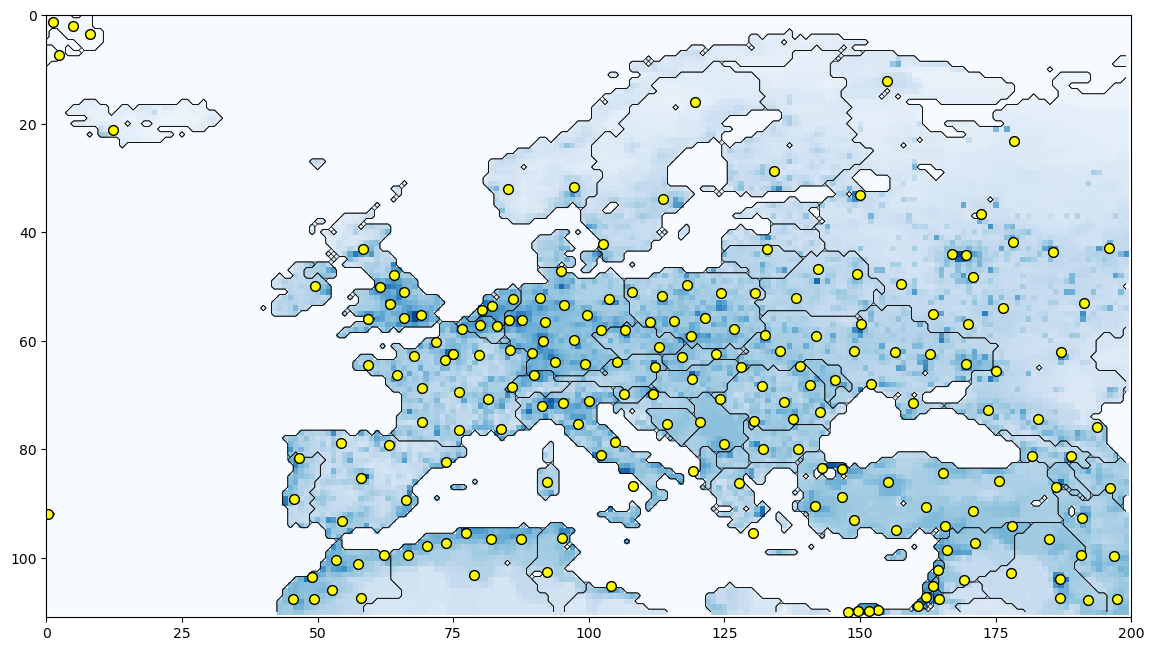

In [6]:
weights   = utils.population.flatten()*1.0

centroids = wkmeans(centroids_init, locations, weights, True, 40, gif_dir="plots/gif_frames")

utils.plot(centroids[:,0], centroids[:,1], "plots/final_centroids_k200.png")

In [7]:
def generate_gif(frame_dir, gif_path="plots/centroid_animation.gif", duration=0.5):
    frames = sorted([f for f in os.listdir(frame_dir) if f.endswith(".png")])
    images = [imageio.imread(os.path.join(frame_dir, f)) for f in frames]
    imageio.mimsave(gif_path, images, duration=duration)

In [8]:
generate_gif("plots/gif_frames")

/var/folders/kb/nvs3vt_s7_1fbjz8lm6rnn5w0000gn/T/ipykernel_84938/3379918872.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(frame_dir, f)) for f in frames]


Observe that the k-means algorithm is non-convex, and arrives in local optima of different quality depending on the initialization:

In [ ]:
for i in range(5):
    wkmeans(initialize(200, utils.population), locations, weights, False, 40)

Iteration 40: J=6.9244
